In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.stats import t

import statsmodels.api as sm
import statistics

from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import norm

In [15]:
pd.options.display.max_rows = 300

## T-distribution

3rd and 4th momentum

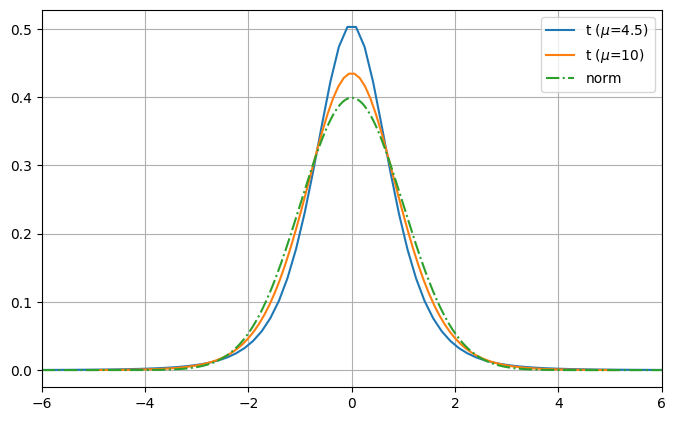

In [16]:
plt.figure(figsize = (8,5), dpi = 100)
#--------- t ----------
for mu in [4.5,10]:
    rv = t(mu, loc = 0, scale = np.sqrt((mu-2)/mu))
    x = np.linspace(rv.ppf(0.0001), rv.ppf(0.9999), 100)
    y = rv.pdf(x)
    plt.xlim(-6,6)
    plt.plot(x,y, label = rf"t ($\mu$={mu})")

#--------- normal -----
x_axis = np.arange(-6,6, 0.001)
plt.plot(x_axis, norm.pdf(x_axis, 0, 1), "-.", label = "norm")

plt.legend(); plt.grid()
plt.show()

In [17]:
from arch import arch_model
import arch.data.sp500
import datetime as dt
import sys

In [18]:
data = arch.data.sp500.load()
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-04,1229.229980,1248.810059,1219.099976,1228.099976,1228.099976,877000000
1999-01-05,1228.099976,1246.109985,1228.099976,1244.780029,1244.780029,775000000
1999-01-06,1244.780029,1272.500000,1244.780029,1272.339966,1272.339966,986900000
1999-01-07,1272.339966,1272.339966,1257.680054,1269.729980,1269.729980,863000000
1999-01-08,1269.729980,1278.239990,1261.819946,1275.089966,1275.089966,937800000


In [19]:
len(data.dropna()) == len(data)

True

In [20]:
rt = 100*data[['Adj Close']].pct_change().dropna()

remember that here we multiplied daily return by 100.

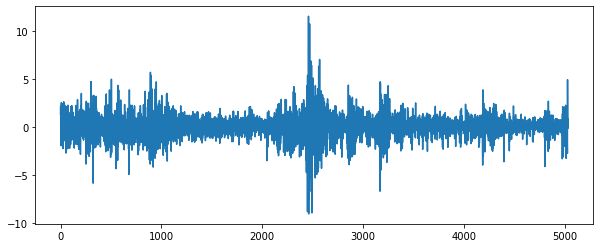

In [21]:
plt.figure(figsize = (10,4))
plt.plot(np.arange(len(rt)), rt)
plt.show()

By momentum method:
Suppose $X\sim \lambda t(\nu)$
* $$\lambda = (\frac{\mu_2(\nu-2)}{\nu})^{1/2}$$
* $$\nu = \frac{4\mu_4-6\mu_2^2}{\mu_4-2\mu_2^2}$$

en q
* mu2: avg {x xexp 2} each rts;
* mu4: avg {x xexp 4} each rts;
* nu:  1+(6* mu2* mu2%(mu4-3 * mu2* mu2))
* lambda: sqrt(mu2* (nu-2)%nu )

In [22]:
mu2 = (rt.values**2).mean()
mu4 = (rt.values**4).mean()
mu2, mu4

(1.4475583691870835, 23.7398514923449)

In [23]:
nu = (4*mu4-6*mu2*mu2)/(mu4-2*mu2*mu2)
lambd = np.sqrt(mu2*(nu-2)/nu)
nu, lambd

(4.21437670694364, 0.8721217509837789)

In [24]:
sigma_n = np.sqrt(rt.values.var())

In [25]:
import matplotlib.patches as patches

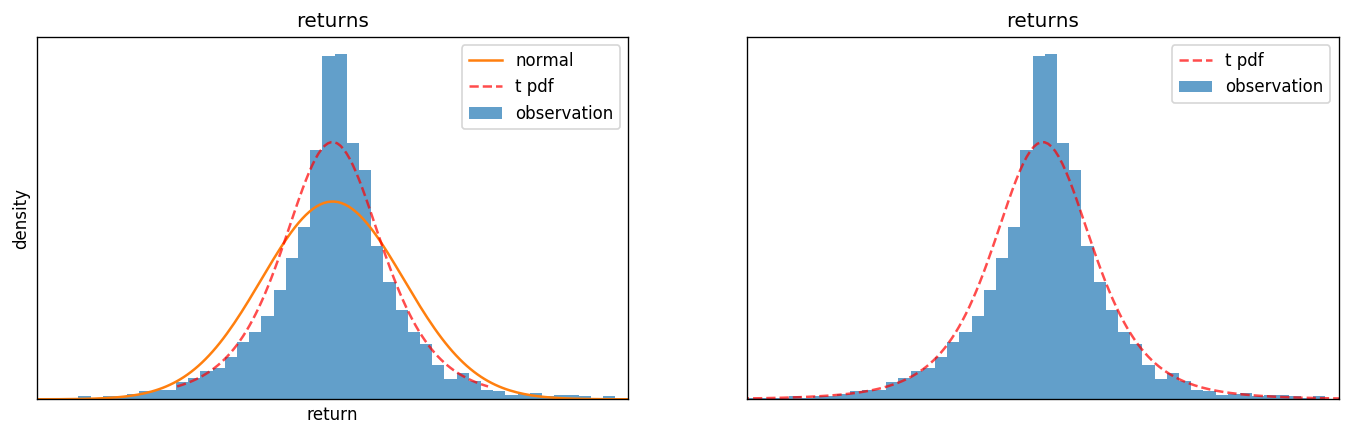

In [29]:
nr = 1; nc = 2
fig, axs = plt.subplots(nrows = nr, ncols = nc, figsize = (14,4), dpi = 120, subplot_kw={'xticks':[], 'yticks':[]})


ax = axs.flat[0]
ax.hist(rt.values.reshape(1,-1)[0], bins = 100, density = True, label = 'observation', alpha = 0.7)
mu = 0; ns = 5
x1 = np.linspace(mu-ns*sigma_n, mu+ns*sigma_n, 200)
x2 = np.linspace(mu-ns*(nu-2)/nu, mu+ns*(nu-2)/nu, 100)
ax.set_title('returns')
ax.plot(x1, stats.norm.pdf(x1, 0, sigma_n), label = 'normal')
ax.plot(x2, t.pdf(x2, df=nu, loc = 0, scale = lambd), 'r--', label = 't pdf', alpha = 0.7)
ax.set_xlabel("return")
ax.set_ylabel("density")
ax.set_xlim(-5,5)
ax.legend()
ax.grid()

ax = axs.flat[1]
ax.hist(rt.values.reshape(1,-1)[0], bins = 100, density = True, label = 'observation', alpha = 0.7)
mu = 0; ns = 5
x1 = np.linspace(mu-ns*sigma_n, mu+ns*sigma_n, 200)
# x2 = np.linspace(mu-ns*(nu-2)/nu, mu+ns*(nu-2)/nu, 100)
ax.set_title('returns')
# ax.plot(x1, stats.norm.pdf(x1, 0, sigma_n), label = 'normal')
ax.plot(x1, t.pdf(x1, df=nu, loc = 0, scale = lambd), 'r--', label = 't pdf', alpha = 0.7)
ax.set_xlim(-5,5)
ax.legend()
ax.grid()


plt.show()

* Should try generalized error distribution

## Q-Q Plots

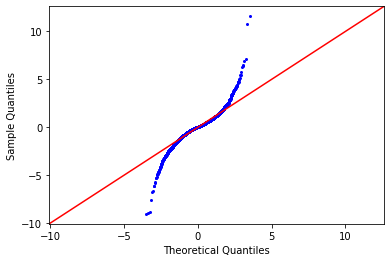

In [123]:
sm.qqplot(rt.values.reshape(1,-1)[0], line = '45', marker = '.', markersize = 4)
plt.show()

## ARCH and GARCH

### Test for white noise
Ljung-box test

In [125]:
returns = rt.values.reshape(1,-1)[0]
returns

array([ 1.35819993,  2.21404074, -0.20513275, ...,  0.85626808,
       -0.12415826,  0.84924844])

In [129]:
# ARCH(1,1)
tmp = sm.tsa.ARMA(returns, (1,1)).fit(disp=-1)
sm.stats.acorr_ljungbox(tmp.resid, lags=[5,10,20])

(array([13.63074378, 19.79696421, 72.65030649]),
 array([1.81331826e-02, 3.12326181e-02, 6.68598977e-08]))

## VaR by EWMA

In [137]:
alpha = 0.99
pd.DataFrame.ewm(rt, min_periods=255, com = 1/alpha - 1 )

EWM [com=0.010101010101010166,min_periods=255,adjust=True,ignore_na=False,axis=0]

## Volatility by GARCH

In [182]:
import datetime as dt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import scipy.stats as stats
import pylab
import statistics


In [161]:
rt = rt.rename(columns = {'Adj Close':'rt'})

In [220]:
ES = data[['Adj Close']]
ES= pd.concat([ES, rt], axis = 1).dropna()
ES.tail()

,Adj Close,rt
Date,,
2018-12-24,2351.100098,-2.711225
2018-12-26,2467.699951,4.959374
2018-12-27,2488.830078,0.856268
2018-12-28,2485.739990,-0.124158
2018-12-31,2506.850098,0.849248


In [169]:
last_obs = '2015-01-04'

In [170]:
from arch.univariate import ConstantMean, GARCH, StudentsT

In [171]:
md1 = ConstantMean(ES.rt)
md1.volatility = GARCH(p=1, o=0, q = 1)
res1 = md1.fit(update_freq=0, disp = 'off', first_obs=0, last_obs = last_obs)
print(res1.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                     rt   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -5808.15
Distribution:                  Normal   AIC:                           11624.3
Method:            Maximum Likelihood   BIC:                           11649.5
                                        No. Observations:                 4025
Date:                Tue, Aug 25 2020   Df Residuals:                     4021
Time:                        22:26:02   Df Model:                            4
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0527  1.379e-02      3.821  1.327e-04 [2.

In [172]:
# import seaborn
# seaborn.set_style('darkgrid')
# plt.rc("figure", figsize=(16,6))
# plt.rc("savefig", dpi = 90)
# plt.rc("font", family = "sans-serif")
# plt.rc("font", size = 14)

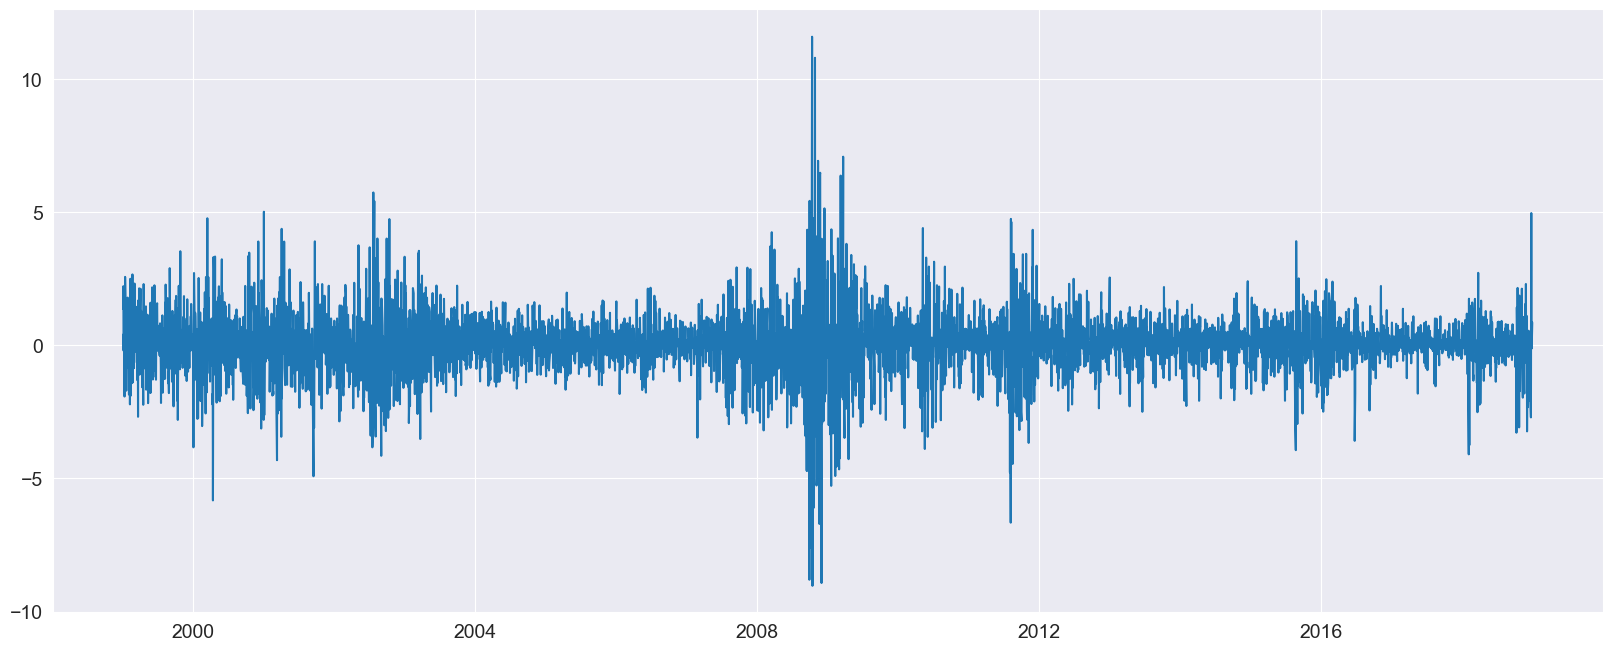

In [174]:
plt.figure(figsize = (20,8), dpi = 100)
plt.plot(ES.rt)
plt.show()

In [176]:
md2 = ConstantMean(ES.rt)
md2.volatility = GARCH(p=1, o=0, q = 1)
md2.distribution = StudentsT()
res2 = md2.fit(update_freq=0, disp = 'off', first_obs=0, last_obs = last_obs)
print(res2.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                           rt   R-squared:                      -0.001
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                            GARCH   Log-Likelihood:               -5757.47
Distribution:      Standardized Student's t   AIC:                           11524.9
Method:                  Maximum Likelihood   BIC:                           11556.4
                                              No. Observations:                 4025
Date:                      Tue, Aug 25 2020   Df Residuals:                     4020
Time:                              22:39:22   Df Model:                            5
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

<Figure size 2000x1000 with 0 Axes>

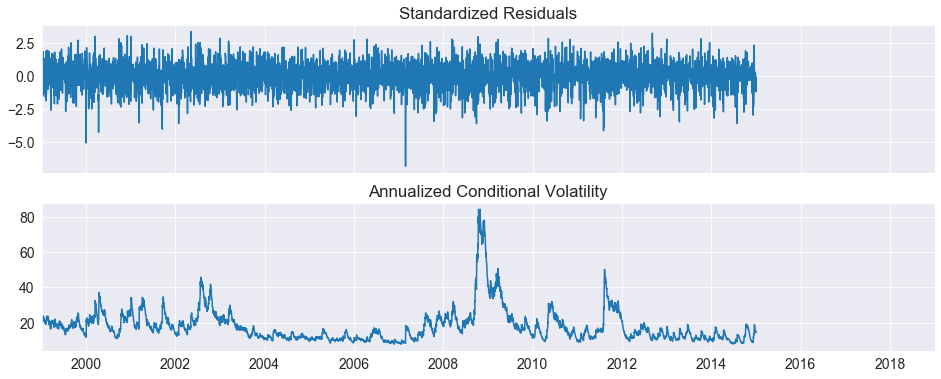

In [179]:
plt.figure(figsize=(20,10), dpi = 100)
res2.plot(annualize = 'D')
plt.show()

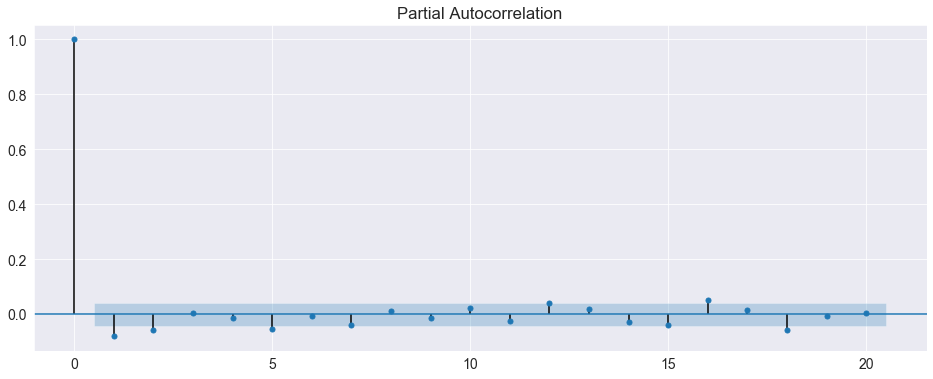

In [184]:
mylag = 20
plot_pacf(res2.resid.dropna(), alpha = 0.01, lags = mylag)
plt.show()

In [244]:
ES = data[['Adj Close']]
ES= pd.concat([ES, rt], axis = 1).dropna()
ES.tail()

,Adj Close,rt
Date,,
2018-12-24,2351.100098,-2.711225
2018-12-26,2467.699951,4.959374
2018-12-27,2488.830078,0.856268
2018-12-28,2485.739990,-0.124158
2018-12-31,2506.850098,0.849248


In [245]:
ES.reset_index(inplace=True)

In [246]:
ES.Date = ES.Date.apply(lambda x: x.to_pydatetime())

In [250]:
ES.Date.values

array(['1999-01-05T00:00:00.000000000', '1999-01-06T00:00:00.000000000',
       '1999-01-07T00:00:00.000000000', ...,
       '2018-12-27T00:00:00.000000000', '2018-12-28T00:00:00.000000000',
       '2018-12-31T00:00:00.000000000'], dtype='datetime64[ns]')

ConversionError: Failed to convert value(s) to axis units: array([Timestamp('1999-01-05 00:00:00'), 1.3581999288305502], dtype=object)

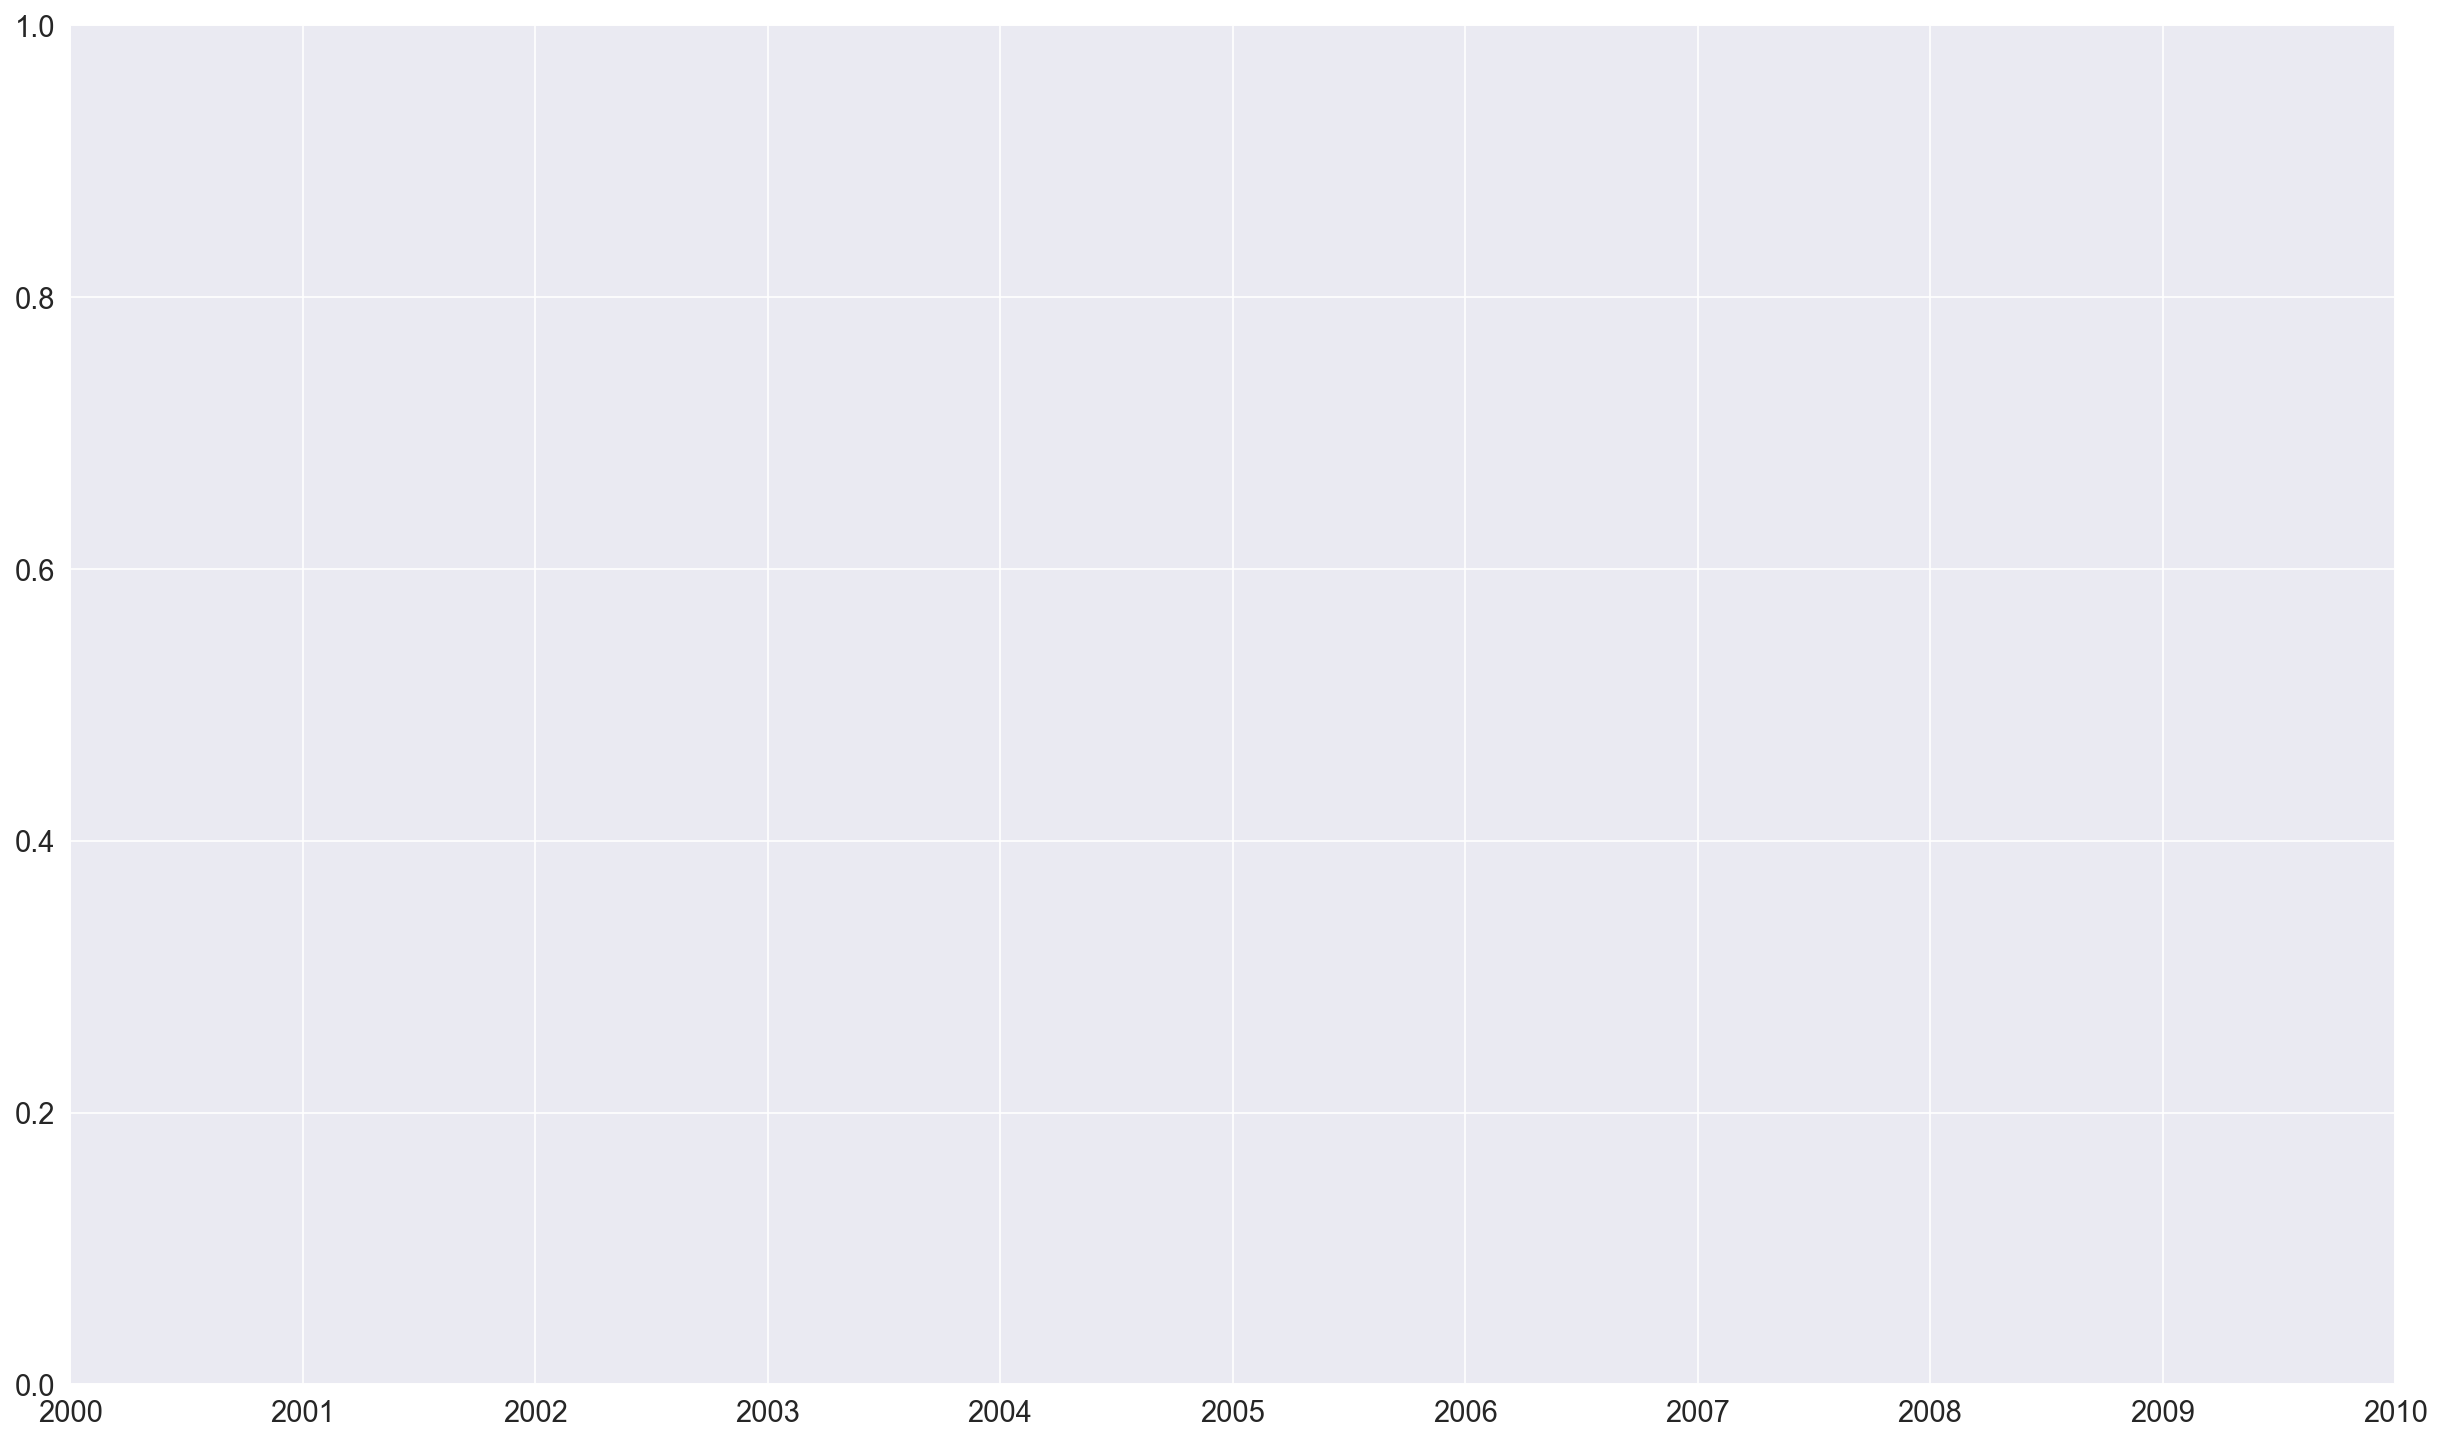

In [243]:
plt.figure(figsize = (20,12), dpi = 150)
nday = len(ES)

X = np.array(ES[['Date','rt']])
for i in range(nday):
    plt.plot([X[i,0], X[i,1]], [0,(X[i,1])], 'black', alpha = 0.5)

plt.plot(np.arange(0, nday), res1.conditional_volatility, label = 'GARCH(1,1) fit')
plt.plot( np.arange(0, nday), res2.conditional_volatility, label = 'GARCH(1,1) t fit')
plt.plot( np.arange(0, nday), np.sqrt(res1.forecast().variance()), label = 'GARCH(1,1) forcast')
plt.plot( np.arange(0, nday), np.sqrt(res2.forecast().variance()), label = 'GARCH(1,1) t forcast')

plt.grid(); plt.legend(); plt.title('S&P 500')
plt.show()

array([[ 1.35819993],
       [ 2.21404074],
       [-0.20513275],
       ...,
       [ 0.85626808],
       [-0.12415826],
       [ 0.84924844]])

## Draw breaks up point

for i in range(500):
    if (X >):
        plt.scatter(X[i,0], X[i,1], color = 'white', marker = "^", edgecolors = 'b', s = 50)
        if (X):
            breaksup +=1
        else:
plt.annotate('95% breaks up: {:.2%} \n down:{:.2%}'.format(breaksup, breaksdown), xy = (0.05, 0.1), xycoords = 'axes fraction')

## Last work day

In [82]:
today = dt.date.today()
today

datetime.date(2020, 8, 25)

In [107]:
today = dt.date(2020,8,17)

In [108]:
offset = max(1,(today.weekday()+6)%7 - 3)

In [110]:
last_workday = today - dt.timedelta(offset)
last_workday

datetime.date(2020, 8, 14)